# Importing dependancies

In [1]:
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace

import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model definition

We can use the state variables (position of cart, angle of pole)

In [3]:
class ActorCritic(nn.Module):

    def __init__(self, output_size):
        super(ActorCritic, self).__init__()
        self.conv1 = nn.LazyConv2d(8, 5)
        self.conv2 = nn.LazyConv2d(16, 5)
        self.conv3 = nn.LazyConv2d(16, 7)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        self.flatten = nn.Flatten()
        
        self.fn1 = nn.LazyLinear(32)
        self.a1 = nn.LazyLinear(8) 
        self.a2 = nn.LazyLinear(output_size) 
        self.c1 = nn.LazyLinear(8) 
        self.c2 = nn.LazyLinear(1) 

        self.act = nn.PReLU()
        self.softmax = nn.Softmax()

    def forward(self, input):
        x = self.act(self.bn1(self.conv1(input)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.act(self.fn1(x))
        a_output = self.act(self.a1(x))
        a_output = self.softmax(self.a2(x))
        c_output = self.act(self.c1(x))
        c_output = self.c2(x)
        return a_output, c_output

# Creating the agent

In [4]:
class ActorCriticAgent:
    def __init__(self, env):

        self.action_size = env.action_space.n # output size
        
        self.model = ActorCritic(self.action_size).to(device)

        self.critic_loss = nn.SmoothL1Loss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

        self.num_epochs = 1000
        self.gamma = 0.99

    def act(self, state):
        action_prob, critique = self.model(state)
        m = Categorical(action_prob)
        action = m.sample()
        return action.item(), critique, m.log_prob(action)
    
    def act_ideal(self, state):
        actions, critique = self.model(state)
        return actions.max(1)[1].item()
    
    def train_step(self, log_probs, critiques, rewards):
        
        discount_reward_sum = 0
        returns = []

        for reward in rewards[::-1]:
            discount_reward_sum = reward + self.gamma * discount_reward_sum
            returns.insert(0, discount_reward_sum)

        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + np.finfo(np.float32).eps.item())
        returns = returns.tolist()

        policy_losses = []
        critic_losses = []
        for log_prob, critique, r in zip(log_probs, critiques, returns):
            advantage = r - critique

            policy_losses.append(-log_prob * advantage)
            critic_losses.append(self.critic_loss(critique, torch.Tensor([r]).to(device)))
        
        loss = torch.stack(policy_losses).sum() + torch.stack(critic_losses).sum()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    
    def train(self, env, print_epochs=False, render=False, checkpoint=True):

        scores = []

        for epoch in range(self.num_epochs):
            done = False
            curr_state = env.reset()
            curr_state = torch.Tensor(np.array(curr_state)).to(device)
            score = 0

            log_probs = []
            critiques = []
            rewards = []
            
            while not done:
                if render:
                    env.render()

                action, critique, log_prob = self.act(curr_state.unsqueeze(0))
                curr_state, reward, done, _ = env.step(action)
                curr_state = torch.Tensor(np.array(curr_state)).to(device)

                log_probs.append(log_prob)
                critiques.append(critique)
                rewards.append(reward)

                score += reward

            self.train_step(log_probs, critiques, rewards)

            scores.append(score)

            if print_epochs:
                print("Epoch: " + str(epoch + 1) + ". Score is: " + str(score))
            
            if checkpoint and epoch % 50 == 0:
                torch.save(self, 'mario_ac.pt')
                np.save('mario_ac_scores.npy', scores)

        torch.save(self, 'mario_ac.pt')
        np.save('mario_ac_scores.npy', scores)

            
        return scores


In [5]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Training the agent

In [6]:
env = gym.make("BreakoutNoFrameskip-v4")

env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=64)
env = FrameStack(env, num_stack=4)

agent = ActorCriticAgent(env)
scores = agent.train(env, print_epochs=True, checkpoint=True)

C:\Users\Sean Jan's PC\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\Sean Jan's PC\AppData\Local\Temp\ipykernel_22536\3179329841.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a_output = self.softmax(self.a2(x))
C:\Users\Sean Jan's PC\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:912: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch: 1. Score is: 969.0
Epoch: 2. Score is: 609.0
Epoch: 3. Score is: 619.0
Epoch: 4. Score is: 1022.0
Epoch: 5. Score is: 232.0
Epoch: 6. Score is: 1046.0
Epoch: 7. Score is: 1046.0
Epoch: 8. Score is: 232.0
Epoch: 9. Score is: 1389.0
Epoch: 10. Score is: 232.0
Epoch: 11. Score is: 232.0
Epoch: 12. Score is: 630.0
Epoch: 13. Score is: 800.0
Epoch: 14. Score is: 1298.0
Epoch: 15. Score is: 1025.0
Epoch: 16. Score is: 604.0
Epoch: 17. Score is: 232.0
Epoch: 18. Score is: 1310.0
Epoch: 19. Score is: 1294.0
Epoch: 20. Score is: 232.0
Epoch: 21. Score is: 1028.0
Epoch: 22. Score is: 636.0
Epoch: 23. Score is: 1029.0
Epoch: 24. Score is: 809.0
Epoch: 25. Score is: 810.0
Epoch: 26. Score is: 803.0
Epoch: 27. Score is: 1048.0
Epoch: 28. Score is: 1299.0
Epoch: 29. Score is: 808.0
Epoch: 30. Score is: 1298.0
Epoch: 31. Score is: 593.0
Epoch: 32. Score is: 1276.0
Epoch: 33. Score is: 598.0
Epoch: 34. Score is: 1011.0
Epoch: 35. Score is: 1132.0
Epoch: 36. Score is: 1151.0
Epoch: 37. Score is:

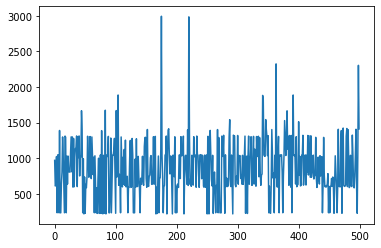

In [7]:
plt.plot(scores\)